In [58]:
import onnx
import tvm
from tvm import relay, transform
from tvm.contrib import graph_executor as runtime
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
import cv2
import numpy as np

In [2]:
model_dir = Path.cwd().parent / "models" / "ultraface"
model_dir.exists()

True

In [4]:
model_path = model_dir / "version-RFB-320.onnx"
model_path.exists()

True

In [5]:
onnx_model = onnx.load(str(model_path))

In [7]:
onnx_model.graph.input[0].type

tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 240
    }
    dim {
      dim_value: 320
    }
  }
}

In [9]:
target = "llvm"

input_name = "input"
input_dtype = "float32"
input_shape = (1, 3, 240, 320)
shape_dict = {input_name: input_shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict, freeze_params=True)

target = "llvm"
with transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)
    lib.export_library(str(model_path.with_suffix(".so")))

In [12]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))

In [14]:
assets_dir = Path.cwd().parent / "assets"
assets_dir.exists()

True

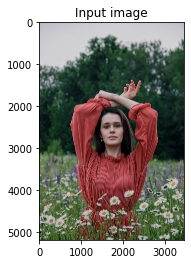

In [17]:
original_image = imageio.imread(assets_dir / "single_image.jpg")
plt.imshow(original_image)
plt.title("Input image")
plt.show()

In [50]:
image = cv2.resize(original_image, (320, 240))
image_mean = np.array([127, 127, 127])
image = (image - image_mean) / 128
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)
module.set_input("input", tvm.nd.array(image))
module.run()

In [51]:
onnx_model.graph.output

[name: "scores"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 4420
      }
      dim {
        dim_value: 2
      }
    }
  }
}
, name: "boxes"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 4420
      }
      dim {
        dim_value: 4
      }
    }
  }
}
]

In [52]:
scores = module.get_output(0).numpy()
boxes = module.get_output(1).numpy()

In [53]:
scores.shape, boxes.shape

((1, 4420, 2), (1, 4420, 4))

In [54]:
def area_of(left_top, right_bottom):
    """
    Compute the areas of rectangles given two corners.
    Args:
        left_top (N, 2): left top corner.
        right_bottom (N, 2): right bottom corner.
    Returns:
        area (N): return the area.
    """
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[..., 0] * hw[..., 1]

def iou_of(boxes0, boxes1, eps=1e-5):
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Args:
        boxes0 (N, 4): ground truth boxes.
        boxes1 (N or 1, 4): predicted boxes.
        eps: a small number to avoid 0 as denominator.
    Returns:
        iou (N): IoU values.
    """
    overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
    overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
    area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)

def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    """
    Perform hard non-maximum-supression to filter out boxes with iou greater
    than threshold
    Args:
        box_scores (N, 5): boxes in corner-form and probabilities.
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
        candidate_size: only consider the candidates with the highest scores.
    Returns:
        picked: a list of indexes of the kept boxes
    """
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if 0 < top_k == len(picked) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]

    return box_scores[picked, :]

def predict(width, height, confidences, boxes, prob_threshold, iou_threshold=0.5, top_k=-1):
    """
    Select boxes that contain human faces
    Args:
        width: original image width
        height: original image height
        confidences (N, 2): confidence array
        boxes (N, 4): boxes array in corner-form
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
    Returns:
        boxes (k, 4): an array of boxes kept
        labels (k): an array of labels for each boxes kept
        probs (k): an array of probabilities for each boxes being in corresponding labels
    """
    boxes = boxes[0]
    confidences = confidences[0]
    #print(boxes)
    #print(confidences)

    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        #print(confidences.shape[1])
        probs = confidences[:, class_index]
        #print(probs)
        mask = probs > prob_threshold
        probs = probs[mask]

        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        #print(subset_boxes)
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = hard_nms(box_probs,
           iou_threshold=iou_threshold,
           top_k=top_k,
           )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]

In [55]:
height, width, _ = original_image.shape
result = predict(width, height, scores, boxes, 0.7)

In [57]:
result

(array([[1479, 2193, 2017, 2955]], dtype=int32),
 array([1]),
 array([0.9998511], dtype=float32))

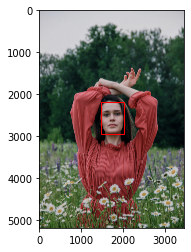

In [60]:
x1, y1, x2, y2 = result[0][0]
w = x2 - x1
h = y2 - y1
plt.imshow(original_image)
plt.gca().add_patch(Rectangle((x1,y1), w, h,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
plt.show()

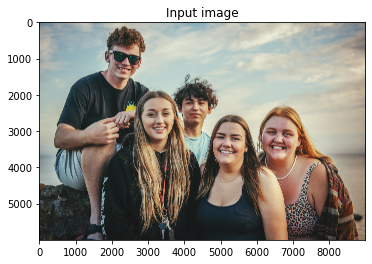

In [61]:
original_image = imageio.imread(assets_dir / "multiple_faces_image.jpg")
plt.imshow(original_image)
plt.title("Input image")
plt.show()

In [65]:
image = cv2.resize(original_image, (320, 240))
image_mean = np.array([127, 127, 127])
image = (image - image_mean) / 128
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)
module.set_input("input", tvm.nd.array(image))
module.run()
scores = module.get_output(0).numpy()
boxes = module.get_output(1).numpy()
height, width, _ = original_image.shape
result = predict(width, height, scores, boxes, 0.7)
print(result)

(array([[4805, 2801, 5641, 3867],
       [6146, 2651, 7100, 3723],
       [1918,  618, 2792, 1632],
       [3963, 1909, 4644, 2818],
       [2834, 2096, 3666, 3170]], dtype=int32), array([1, 1, 1, 1, 1]), array([0.99958855, 0.9994542 , 0.99858814, 0.99763477, 0.9970759 ],
      dtype=float32))


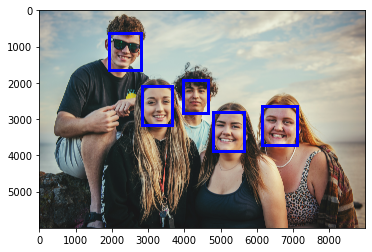

In [70]:
plt.imshow(original_image)
for r in result[0]:
    x1, y1, x2, y2 = r
    w = x2 - x1
    h = y2 - y1
    plt.gca().add_patch(Rectangle((x1,y1), w, h,
                            edgecolor='blue',
                            facecolor='none',
                            lw=3))
plt.show()